# Course 9: Week 3 Assignment

### Scrapping Wikipedia page to get the dataframe

In [1]:
#getting the wikipedia page
import requests
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

#Using beautiful soup to convert url to xml
from bs4 import BeautifulSoup
soup = BeautifulSoup(url,"lxml")

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20181009102647-0000


In [2]:
#exract the table from the wikipedia page
table = soup.find('table',{'class':'wikitable sortable'})
table

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Harbourfront_(Toronto)" title="Harbourfront (Toronto)">Harbourfront</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Regent Park</a>
</td></tr>
<tr>
<td>M6A</td>

In [3]:
#extract the contents of the table
links = table.find_all('td')

In [4]:
# creating empty dataframe
import pandas as pd
column_name = ['Postal Code','Borough','Neighborhood']
df = pd.DataFrame(columns=column_name)
df

,Postal Code,Borough,Neighborhood


In [5]:
#populating the dataframe
import re
i = 0
while i < len(links):
    postcode = re.findall(r'<td>(.*?)</td>',str(links[i]))
    pc = postcode[0]
    borough = re.findall(r'<td>(.*?)</td>',str(links[i+1]))
    if len(borough) == 0:
        borough = re.findall(r'<td>(.*?\n)</td>',str(links[i+1]))
    
    if '<a href'in borough[0]:
        b1 = re.findall(r'>(.*?)</a>',borough[0])
        if len(b1) == 0:
            b1 = re.findall(r'>(.*?\n)</a>',borough[0])
        b = b1[0]
    else:
        b = borough[0]
    
    neigh = re.findall(r'<td>(.*?)</td>',str(links[i+2]))
    if len(neigh) == 0:
        neigh = re.findall(r'<td>(.*?\n)</td>',str(links[i+2]))
    if '<a href' in neigh[0]:
        n1 = re.findall(r'>(.*?)</a>',neigh[0])
        #if len(n1) == 0:
         #   n1 = re.findall(r'>(.*?\n)</a>',neigh[0])
        n = n1[0]
    else:
        n = neigh[0]
    
    row = [pc,b,n]
    df.loc[len(df)] = row
    i+=3

In [6]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned\n
1,M2A,Not assigned,Not assigned\n
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Cleaning up the dataframe

In [7]:
#extracting names that are present within the <a></a> tags
for index, row in df.iterrows():
    if '<a class' in row['Neighborhood']:
        newname =  re.findall(r'>(.*?)</a>',row['Neighborhood'])
        row['Neighborhood'] = newname[0]
    
    if '<a class' in row['Borough']:
        newnames =  re.findall(r'>(.*?)</a>',row['Borough'])
        row['Borough'] = newnames[0]

In [8]:
#eliminating the rows that have Borough as 'Not assigned'
df = df[df['Borough'] != 'Not assigned']
df = df.reset_index()

In [9]:
del df['index']
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [11]:
#Cleaning up the data
for index, rows in df.iterrows():
    pc = rows['Postal Code']
    b = rows['Borough']
    n = rows['Neighborhood']
    if 'Not assigned' in n:
        newn = b
    else:
        newn = n.strip('\n')
    df.loc[index] = [pc,b,newn]

In [12]:
# Grouping the Neighborhoods according to Postal Code
df = df.groupby(['Postal Code','Borough'])['Neighborhood'].apply(', '.join).reset_index()

In [13]:
df.head(12)

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [14]:
#Shape of the dataset
df.shape

(103, 3)

## Part 2 Getting the latitude and longtitude of each Postal Code

In [15]:
#importing necessary libraries
!conda install -c conda-forge geopy --yes 
import geopy.geocoders 

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/ibm/conda/miniconda3

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ca-certificates-2018.8.24  |       ha4d7672_0         136 KB  conda-forge
    conda-4.5.11               |           py35_0         636 KB  conda-forge
    geopy-1.17.0               |             py_0          49 KB  conda-forge
    openssl-1.0.2p             |       h470a237_0         3.5 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0             conda-forge
    geopy:       

#### Due to Geocoders function taking too much time, have gone for the csv file approach

In [16]:
#getting the coordinates dataframe
coord = pd.read_csv('http://cocl.us/Geospatial_data')

In [17]:
#merging the two dataframes using column PostalCode
final_df = pd.merge(df,coord,on="Postal Code")
final_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [18]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(final_df['Borough'].unique()),
        final_df.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


In [19]:
final_df.head(12)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## Part 3 Analysis of Neighborhoods

In [20]:
#Getting the names of the Boroughs
final_df["Borough"].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       "Queen's Park", 'Mississauga', 'Etobicoke'], dtype=object)

In [21]:
#Extracting only those Borough that contain the word 'Toronto'
toronto_data = final_df[df['Borough'].isin(['West Toronto','East Toronto','Central Toronto','Downtown Toronto'])].reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [22]:
#Getting coordinates of Toronto
address = 'Toronto, Canada'
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [23]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [25]:
# The code was removed by Watson Studio for sharing.

In [26]:
#get nearby venues of each Neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
LIMIT = 100 
radius = 500
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [28]:
#Viewing the dataframe
print(toronto_venues.shape)
toronto_venues.head()

(1710, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
1,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
2,The Beaches,43.676357,-79.293031,St-Denis Studios Inc.,43.675031,-79.288022,Music Venue
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Beaches,43.676357,-79.293031,Beaches Dance & Music Studio,43.680595,-79.291300,Dance Studio


In [29]:
#Grouping the Neighborhoods by counting the venues
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
Business reply mail Processing Centre969 Eastern,16,16,16,16,16,16
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",49,49,49,49,49,49
Central Bay Street,85,85,85,85,85,85
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,16,16,16,16,16,16


In [30]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


In [31]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#Grouping the neighborhoods
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.01
1,Berczy Park,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Business reply mail Processing Centre969 Eastern,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.00,0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,...,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Cabbagetown, St. James Town",0.020408,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Central Bay Street,0.011765,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.000000,0.011765,0.000000,0.000000,0.011765,0.000000,0.00
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.01,0.010000,0.00000,0.000000,0.060000,0.000000,0.040000,0.010000,0.000000,0.00
8,Christie,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Church and Wellesley,0.011494,0.00,0.011494,0.011494,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.000000,0.011494,0.011494,0.011494,0.000000,0.011494,0.00


#### Printing the top 5 venues of each Neighborhood

In [33]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.06
2           Steakhouse  0.04
3      Thai Restaurant  0.04
4  American Restaurant  0.04


----Berczy Park----
            venue  freq
0     Coffee Shop  0.07
1    Cocktail Bar  0.05
2      Restaurant  0.04
3  Farmers Market  0.04
4     Cheese Shop  0.04


----Brockton, Exhibition Place, Parkdale Village----
                venue  freq
0         Coffee Shop  0.14
1                Café  0.09
2      Breakfast Spot  0.09
3  Italian Restaurant  0.05
4                 Bar  0.05


----Business reply mail Processing Centre969 Eastern----
                  venue  freq
0            Comic Shop  0.06
1            Restaurant  0.06
2  Fast Food Restaurant  0.06
3                   Spa  0.06
4               Brewery  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
import numpy as np

#### Get the top 10 venues of each neighborhood

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Gym,Steakhouse,Thai Restaurant,American Restaurant,Bar,Hotel,Restaurant,Asian Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Farmers Market,Cheese Shop,Seafood Restaurant,Café,Beer Bar,Bakery,Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Grocery Store,Italian Restaurant,Performing Arts Venue,Office,Pet Store,Nightclub,Climbing Gym
3,Business reply mail Processing Centre969 Eastern,Light Rail Station,Garden,Skate Park,Spa,Farmers Market,Fast Food Restaurant,Brewery,Restaurant,Auto Workshop,Recording Studio
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Terminal,Airport Service,Airport Lounge,Airport Gate,Boat or Ferry,Plane,Sculpture Garden,Harbor / Marina,Airport Food Court,Airport


### Analysis to see which is the optimum number of clusters

#### Since we do not have any idea about the appropriate number of clusters, we use a method called elbow graph to find the optimal number of clusters

In [37]:
from sklearn.cluster import KMeans
cluster_range = range( 1, 20 )
cluster_errors = []
tester = toronto_grouped.drop('Neighborhood', 1)
for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( tester)
    cluster_errors.append( clusters.inertia_ )

In [38]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

In [39]:
clusters_df[0:10]

,cluster_errors,num_clusters
0,2.951934,1
1,2.449698,2
2,1.967831,3
3,1.633921,4
4,1.458921,5
5,1.322077,6
6,1.235972,7
7,1.133307,8
8,0.997894,9
9,0.892665,10


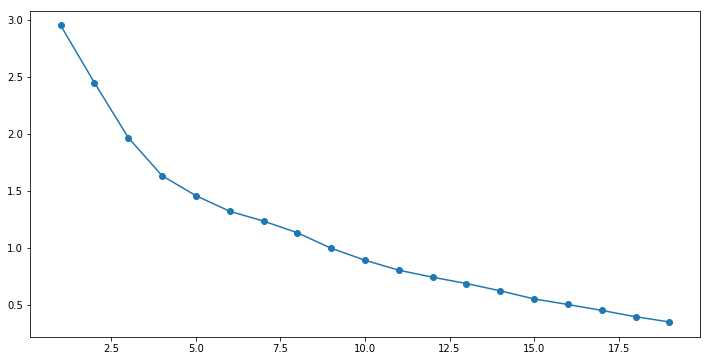

In [40]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

### The elbow is present between 2.5 and 5 so we try for both k = 3 and k = 4

## No. of clusters = 4

In [41]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [42]:
toronto_merged = toronto_data

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Pub,Coffee Shop,Music Venue,Dance Studio,Women's Store,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Dessert Shop,Brewery,Bubble Tea Shop,Café,Pub
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Sandwich Place,Sushi Restaurant,Hotel,Board Shop,Brewery,Burger Joint,Fast Food Restaurant,Burrito Place,Fish & Chips Shop,Italian Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Bakery,Italian Restaurant,Gastropub,American Restaurant,Brewery,Fish Market,Juice Bar,New American Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Swim School,Bus Line,Dim Sum Restaurant,Women's Store,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [44]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### No. of clusters = 3

In [45]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [46]:
toronto_merged = toronto_data

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Coffee Shop,Music Venue,Dance Studio,Women's Store,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Dessert Shop,Brewery,Bubble Tea Shop,Café,Pub
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Sandwich Place,Sushi Restaurant,Hotel,Board Shop,Brewery,Burger Joint,Fast Food Restaurant,Burrito Place,Fish & Chips Shop,Italian Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Bakery,Italian Restaurant,Gastropub,American Restaurant,Brewery,Fish Market,Juice Bar,New American Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Swim School,Bus Line,Dim Sum Restaurant,Women's Store,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [47]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters